## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

### Classifier

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

#Read in preprocessed dataframes:
featureDf = pd.read_pickle('./processed.files/labelled/featureDfnew')
labelledDf = pd.read_pickle('./processed.files/labelled/labelledDfnew')

#Read in preprocessed numpy arrays:
preProcFeats = np.load('./redfeatnew.npy')
preProcLabels = np.load('./processed.files/labelled/labelsnew.npy')

In [20]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [21]:
randForest = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier())

clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

#param_grid = {'estimator__n_estimators': [10, 20, 40, 80], 'estimator__max_features': [100, 400, 1600, 6400]}

# clf = sklearn.model_selection.GridSearchCV(randForest, param_grid=param_grid, scoring='neg_log_loss',\
#                                            cv=k_fold, n_jobs=-1)

# clf.fit(preProcFeats, preProcLabels) #fits data to already labelled set and finds best parameters for fitting
# #print clf.cv_results_
# print clf.best_score_                     
# print clf.best_estimator_
#clf.best_estimator is my randforest classifier that has had it's hyperparamaters tuned by gridsearched


In [22]:
print np.mean(sklearn.model_selection.cross_val_score(clf, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss'))


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
predictTestX = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values
score = sklearn.metrics.log_loss(y_test, predictTestX)
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))
print confuseMatrix

-0.553811776074
[[   5    8    7    0    1    1    1    0]
 [   3 1037   17    0   11   14    2    2]
 [   1   44  204    3   10   81    1    0]
 [   0    1    6   12    4   55    0    0]
 [   1    6   10    2   73   27    0    1]
 [   0    5    9    7   13  763    0    5]
 [   1    2    0    0    0    2  412    1]
 [   0    4    3    1    0    5    0  216]]


(8, 8)


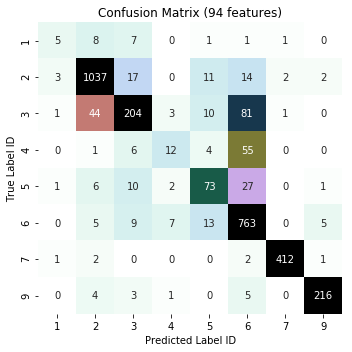

In [23]:

classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix (%d features)'%(preProcFeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix.png')

In [24]:
#Binarise labels:
preProcLabels[preProcLabels != 9] = 0
preProcLabels[preProcLabels == 9] = 1

In [25]:
print np.mean(sklearn.model_selection.cross_val_score(clf, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss'))


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420) #one quarter of data used for testing
predictTestX = clf.fit(X_train, y_train).predict_proba(X_test) #return an array of predicted values

-0.060646544208


In [26]:
# Set positive detection probability as 0.99 based on ROC graph
neg, pos = np.hsplit(predictTestX, 2)
print neg.shape
idx = pos[pos < 0.99].astype(int)
pos[idx] = 0
neg[idx] = 1

predictTestX = np.hstack((neg, pos))

(3100, 1)


In [27]:
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.fit(X_train, y_train).predict(X_test))

(2, 2)


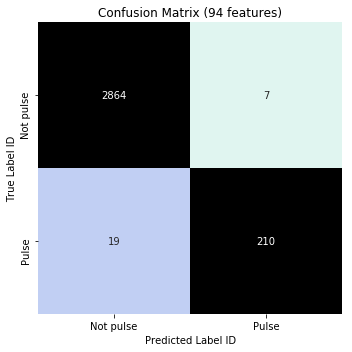

In [28]:
classLabels = ['Not pulse', 'Pulse']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())

#turn the matrix into a dataframe    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

#plot the confusion matrix visually using a heatmap
colormap = plt.cm.cubehelix_r
fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin = 0, vmax = 100, fmt='d', cbar=False, cmap = colormap)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('Predicted Label ID')
plt.ylabel('True Label ID')
plt.title('Confusion Matrix (%d features)'%(preProcFeats.shape[1]))

plt.tight_layout()
plt.savefig('confusion_matrix.png')